In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import numpy as np
import csv
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.formula.api as smf
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
sns.set_style("whitegrid")
sns.set_context("poster")
from collections import Counter

In [2]:
temp_data = {}
for year in range(1999, 2016):
    url = "https://en.t
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    temp_data[int(year)] = soup

https://en.wikipedia.org/wiki/1999–00_UEFA_Champions_League
https://en.wikipedia.org/wiki/2000–01_UEFA_Champions_League
https://en.wikipedia.org/wiki/2001–02_UEFA_Champions_League
https://en.wikipedia.org/wiki/2002–03_UEFA_Champions_League
https://en.wikipedia.org/wiki/2003–04_UEFA_Champions_League
https://en.wikipedia.org/wiki/2004–05_UEFA_Champions_League
https://en.wikipedia.org/wiki/2005–06_UEFA_Champions_League
https://en.wikipedia.org/wiki/2006–07_UEFA_Champions_League
https://en.wikipedia.org/wiki/2007–08_UEFA_Champions_League
https://en.wikipedia.org/wiki/2008–09_UEFA_Champions_League
https://en.wikipedia.org/wiki/2009–10_UEFA_Champions_League
https://en.wikipedia.org/wiki/2010–11_UEFA_Champions_League
https://en.wikipedia.org/wiki/2011–12_UEFA_Champions_League
https://en.wikipedia.org/wiki/2012–13_UEFA_Champions_League
https://en.wikipedia.org/wiki/2013–14_UEFA_Champions_League
https://en.wikipedia.org/wiki/2014–15_UEFA_Champions_League
https://en.wikipedia.org/wiki/2015–16_UE

In [4]:
#with open('Champions_League_Data.csv', 'wb') as f:
#    w = csv.writer(f)
#    for k, v in temp_data.iteritems():
#        w.writerow([k, v])

In [5]:
#with open('Champions_League_Data.csv', 'rb') as fp:
#    r = csv.reader(fp)
#    for row in r:
#        print r
#    temp_data_ = {k : v for k, v in r}

In [6]:
def scrapeChampionLeagueTable(table):
    return [unicode(row.find('td').a['title']) for row in table.find_all("tr")[1:]]

def cleanVals(lst):
    return [" ".join([t_ for t_ in t.split(" ") if len("".join(t_.split('.')))>=4]) for c, t, i in vals]   

def scrapeKnockout(lst):
    vals = []
    for flag in lst:
        try:
            flag.parent.b.text
        except AttributeError:
            vals.append((flag.a['title'], flag.findNext('a').findNext('a')['title'], 0))
        else:
            vals.append((flag.a['title'], flag.findNext('a').findNext('a')['title'], 1))
    return vals

In [7]:
championLeagueDict = {}
for k,v in temp_data.iteritems():
    round_ = 0
    try:
        val = v.find('span', id=['First_group_stage', 'Group_stage']).parent
        print k
    except AttributeError:
        championLeagueDict[k] = {r : [] for r in range(1,7)}
        print k
    else:
        while val:
            split = val.findNext('h3').span.text.split(' ')
            if split[0] == 'Group':
                if split[1] == 'A':
                    round_ += 1
                val = val.findNext('h3')
                try:
                    t = scrapeChampionLeagueTable(val.findNext('table').table)
                except:
                    t = scrapeChampionLeagueTable(val.findNext('table'))
                try:
                    championLeagueDict[k][round_] = championLeagueDict[k][round_] + t
                except KeyError:
                    championLeagueDict[k] = {r : [] for r in range(1,7)}
                    championLeagueDict[k][round_] = t
            else:
                val = False
    vals = scrapeKnockout(v.find('span', id=['Knockout_stage', 'Knockout_phase', 'Bracket']).findNext('table').find_all('span', class_='flagicon'))
    cleaned_vals = []
    for a, (b1, b2, b3) in zip(cleanVals(vals), vals):
        cleaned_vals.append((b1, a, b3))
    championLeagueDict[k][6] = [Counter(cleaned_vals).most_common()[0][0][0]]
    vals = []
    for b1,b2,b3 in cleaned_vals:
        vals.append((b1,b2))
    rev_dict = {}
    for k_, v_ in Counter(vals).most_common():
        try:
            rev_dict[v_].append(k_)
        except KeyError:
            rev_dict[v_] = [k_]
    for k_, v_ in rev_dict.iteritems():
        round__ = round_
        counter = k_
        while counter:
            round__ += 1
            championLeagueDict[k][round__] = championLeagueDict[k][round__]+[c for c, t in v_]
            counter -= 1

NameError: name 'temp_data' is not defined

In [8]:
dictionary_something = {}
for k, v in championLeagueDict.iteritems():
    countries = list(set(v[1]))
    dictionary_something[k] = {c : [] for c in countries}
    for c in countries:
        for _, v_ in v.iteritems():
            val = Counter(v_)[c]
            dictionary_something[k][c].append(val)
print dictionary_something[1999]

KeyError: 1999

In [9]:
# Update Data
#%run scrape_tables.py

In [10]:
def positionate(n, df_):
    df = df_.copy()
    res = df.apply(lambda row: [[row['Year'],data] for data in row['Raw_Data']], axis=1)
    rawdata = pd.DataFrame([i for sublist in res for i in sublist])
    rawdata.columns = ["Year", "Points"]
    t = map(list, zip(*df.Raw_Data)) 
    tt = map(list, zip(*t))
    test = df.apply(lambda row: [[20*(i+1)/float(n), data] for i, data in enumerate(row['Raw_Data'])], axis=1)
    test_ = pd.DataFrame([i for sublist in test for i in sublist])
    test_.columns = ["Rank", "Points"]
    return test_, 19*(pd.DataFrame(t).index)/float(n-1)+1, pd.DataFrame(tt).std(), pd.DataFrame(tt).mean()

def dict_to_parsed_df(d):
    data = []
    for k, v in d.iteritems():
        if v is not None:
            try:
                temp = dict_to_df(v)
                temp.Pts = temp.Pts.astype(int)
                data.append([k, gini_coeff(temp.Pts), temp.Pts.mean(), temp.Pts.std(), temp.Pts, ])
            except AttributeError:
                temp = dict_to_df(v)
                temp.Pts = temp.Points.astype(int)
                temp.drop('Points', axis=1, inplace=True)
                data.append([k, gini_coeff(temp.Pts), temp.Pts.mean(), temp.Pts.std(), temp.Pts, ])
            except:
                print k
    df = pd.DataFrame(data)
    df.columns = ["Year", "Gini", "Mean", "Std", "Raw_Data"]
    df.sort('Year', inplace=True)
    return df.reset_index(drop=True)

def helper(df_):
    df = df_.copy()
    try:
        df['Team']
    except KeyError:
        for i, column in enumerate(df.columns):
            if len(column.split("Team")) > 1:
                df.insert(1, "Team", df.iloc[:,i], allow_duplicates=False)
                df.drop(column, 1, inplace=True)
    return df

def dict_to_df(v):
    try:
        temp = pd.DataFrame(v[1:], columns=v[0])
    except:
        temp = pd.DataFrame(v[1:], columns=v[0][:-1])
#        temp["Pos"] = range(1,len(temp)+1)
#        cols = temp.columns.tolist()
#        cols = cols[-1:] + cols[:-1]
#        temp = temp[cols]
    return helper(temp)

def gini_coeff(x):
    n = len(x)
    s = x.sum()
    r = np.argsort(np.argsort(-x))
    return 1 - (2.0 * (r*x).sum() + s)/(n*s)



In [11]:
def calc_gini(top, n):
    rest = [2*(n-1-top)]*(n-top)
    v = (6*(n-top))
    scores = [l+v for l in range(0, 6*top, 6)]+rest
    return gini_coeff(np.array(scores))

In [12]:
max_gini_dict = {n : max([calc_gini(top, n) for top in range(1,n+1)]) for n in range(16,26,2)}

In [13]:
def plot_gini(ns, colors, data = False):
    for c, n in zip(colors, ns):
        ginis = {top : (calc_gini(top, n), top)  for top in range(1,n+1)}
        a,b = max(ginis.values())
        plt.plot(ginis.keys(), zip(*ginis.values())[0], color=c, label='%i teams, Max of %.03f achieved with %i teams' % (n, a, b))
        plt.scatter(ginis.keys(), zip(*ginis.values())[0], color=c, s=60)
        plt.ylabel("Gini Score")
        plt.xlabel("Number of Dominant Teams");
    plt.legend(loc='lower right', prop={'size':20})
    plt.xlim(0,max(ns)+1)
    plt.ylim(0,.4)

c:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


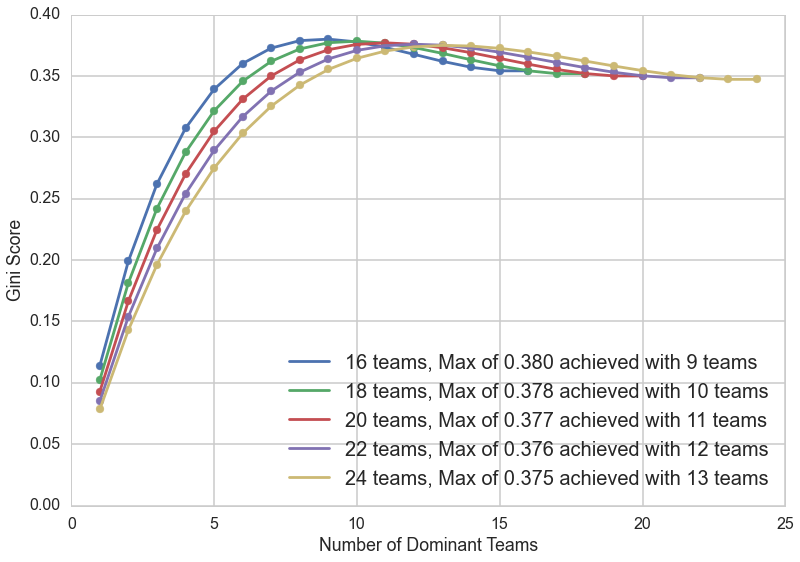

In [14]:
plot_gini(range(16,26,2), sns.color_palette(), data=True)

In [15]:
leagues = ["England", "Germany", "Portugal", "France", "Italy", "Spain"]

In [16]:
d = {}
d_parsed = {}
for l in leagues:
    with open(l+'_PL_tables.json', 'r') as fp:
        d[l] = json.load(fp)
        df = dict_to_parsed_df(d[l])
        df.Year = df.Year.astype(int)
        d_parsed[l] = df

In [17]:
d_df = {k : {int(k_) : dict_to_df(v_) for k_, v_ in v.iteritems() if v_ is not None} for k, v in d.iteritems()}
points_per_win_dict_mask = {k : [sum(r)>len(r)*(len(r)-1)*2 for r in v.Raw_Data] for k, v in d_parsed.iteritems()}
league_size_dict = {k : {y : len(r) for r, y in zip(v.Raw_Data, v.Year)} for k, v in d_parsed.iteritems()}

In [18]:
def league_size_inator(d):
    # Curse you Perry the Platypus!!
    d_ = {}
    for k, v in d.iteritems():
        df = []
        for ((i, (year, gini, mean, std, raw_data)), boool) in zip(v.iterrows(), points_per_win_dict_mask[k]):
            if boool:
                l = league_size_dict[k][year]
                gini_ = gini/max_gini_dict[l]
                raw_data_ = [100*data/float((l-1)*6) for data in raw_data]
                g = (l-1)*l
                t = g*3-sum(raw_data)
                w = g-t
                mean_ = np.array(raw_data_).mean()
                std_ = np.array(raw_data_).std()
                df.append([year, gini_, mean_, std_, raw_data_])
        d_[k] = pd.DataFrame(df, columns = ['Year', 'Gini', 'Mean', 'Std', 'Raw_Data'])
    return d_

In [19]:
d_ = league_size_inator(d_parsed)

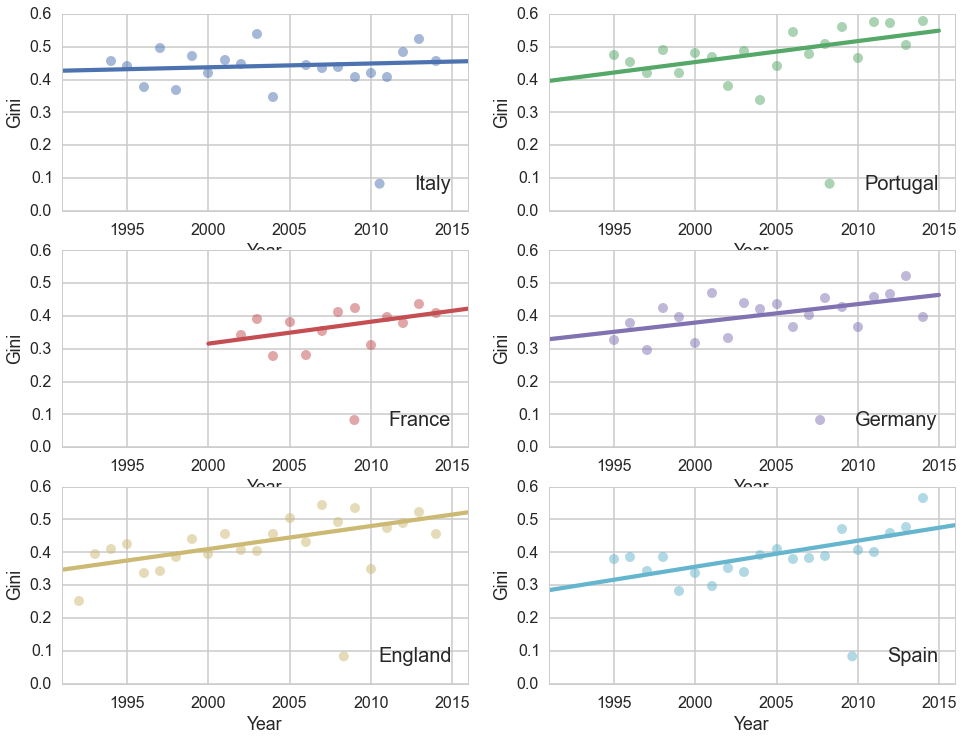

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

for ax, (k, v)  in zip(axes.ravel(), d_.iteritems()):
    sns.regplot(x = 'Year', y = 'Gini', data = v, scatter_kws={'s':100, 'alpha' : .5}, label = k, ci = None, ax=ax)
    ax.legend(loc='lower right', prop={'size':20})
    ax.set_xlim(1991,2016)
    ax.set_ylim(0,.6);

c:\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


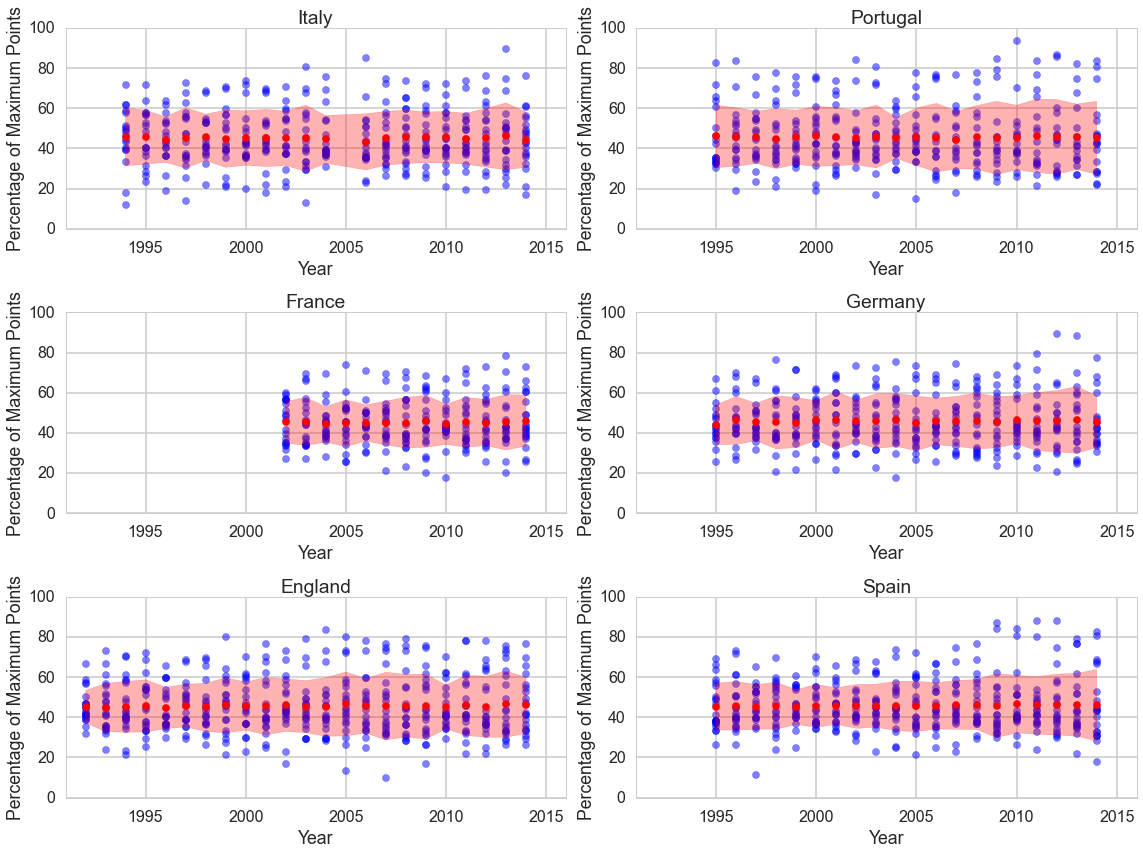

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), tight_layout = True)

for ax, (k, v)  in zip(axes.ravel(), d_.iteritems()):
    res = v.apply(lambda row: [[row['Year'],data] for data in row['Raw_Data']], axis=1)
    rawdata = pd.DataFrame([i for sublist in res for i in sublist])
    rawdata.columns = ["Year", "Points"]
   
    x = v.Year
    y = v.Mean
    std = v.Std

    ax.scatter(x = rawdata['Year'], y = rawdata['Points'], color='b', alpha=.5, s=50)
    ax.scatter(x = x, y = y,color='r', s = 50)
    ax.fill_between(x, y-std, y+std, color='r', alpha=.3)
    ax.set_ylim(0,100)
    ax.set_xlim(1991,2016)
    ax.set_ylabel('Percentage of Maximum Points')
    ax.set_xlabel('Year')
    ax.set_title(k);

In [22]:
for k, v in d_.iteritems():
    lm = smf.ols(formula='Year ~ Gini', data=v).fit()
    print k, lm.summary(), '\n\n\n'
    

Italy                             OLS Regression Results                            
Dep. Variable:                   Year   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.4274
Date:                Fri, 22 Jan 2016   Prob (F-statistic):              0.522
Time:                        14:55:30   Log-Likelihood:                -64.637
No. Observations:                  20   AIC:                             133.3
Df Residuals:                      18   BIC:                             135.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1995.0672     13.663    146.018   

c:\Anaconda\lib\site-packages\scipy\stats\stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


In [24]:
def get_index_inator(d_, n):
    # Mom Phineas and Ferb are making a title sequence
    d_len = {}
    for k, v in d_.iteritems():
        v['n'] = v.apply(lambda row : len(row.Raw_Data), axis = 1)
        for g, g_ in itertools.groupby(reversed(v['n'])):
            if len(list(g_))>=n:
                d_len[k] = g
                break
        vals = v[v.n == d_len[k]].index.tolist()[-n:]
        d_len[k] = (d_len[k], v[vals[0]:vals[0]+n])
    return d_len

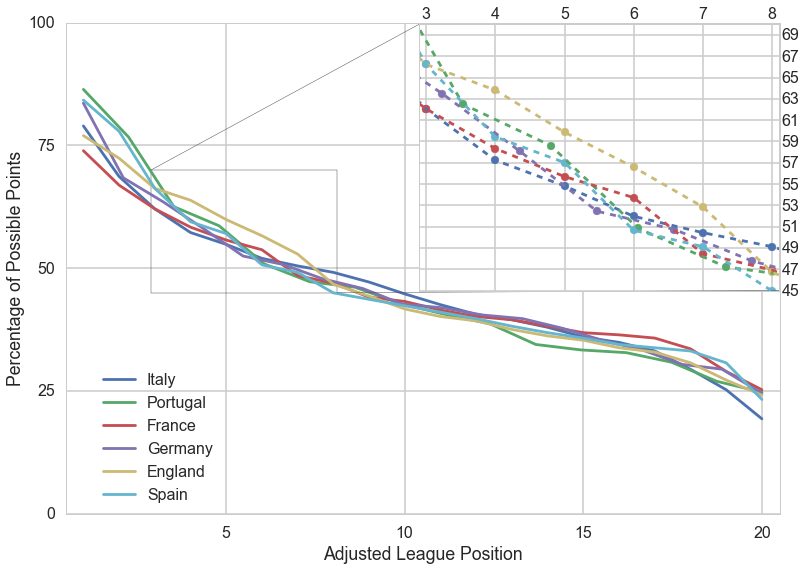

In [234]:
fig, ax = plt.subplots()
n = 4
colors = sns.color_palette()
#plt.figure(figsize=(10, 10))
for c, (k, v) in zip(colors, get_index_inator(d_, n).iteritems()):
    test_, pos, std, mean, = positionate(*v)
    #print k, mean
    plt.plot(pos, mean, color=c, linestyle='-', label = k)
    #plt.fill_between(pos, mean-std, mean+std, color=c, alpha=.3)
    plt.xlim([0.5,20.5])
    plt.ylim([0,100]);
    plt.xlabel('Adjusted League Position')
    plt.ylabel('Percentage of Possible Points')
    plt.yticks(range(0,101,25))
plt.legend(frameon=False, loc = 3, bbox_to_anchor=(0.15, 0.12), bbox_transform=ax.figure.transFigure);


axins2 = inset_axes(ax, 5, 3.7, loc=2, bbox_to_anchor=(0.5, 0.91), bbox_transform=ax.figure.transFigure) # no zoom
for c, (k, v) in zip(colors, get_index_inator(d_, n).iteritems()):
    test_, pos, std, mean, = positionate(*v)
    plt.plot(pos, mean, color=c, label = k, linestyle = 'dashed')
    plt.scatter(pos, mean, color=c, label = k, s = 60)
    plt.xlim([0.5,20.5])
    plt.xticks(range(3,9))
    plt.yticks(range(45,75,2))
    axins2.xaxis.tick_top()
    axins2.yaxis.tick_right()
    axins2.tick_params(direction='in', pad=3)
    plt.ylim([0,100]);
axins2.set_xlim(2.9, 8.1) # apply the x-limits
axins2.set_ylim(45,70)
mark_inset(ax, axins2, loc1=2, loc2=4, fc="None", ec=".3");


In [27]:
#clhist_ = {'Year' : ['Champs', 'RunnerUp', 'Semis', 'Quarters', 'Sixteens', 'Group']}
#clhist = {k: "" for fk in keys}

In [28]:
clhist = {}
for k, v in dictionary_something.iteritems():
    df = pd.DataFrame.from_dict(v).transpose()
    df.columns = ['Round_of_'+str(n) for n in [32,16,8,4,2,1]]
    clhist[k] = df

In [29]:
#  ADDD TITLTE SUTFFFF F F
for k, v in clhist.iteritems():
    v.to_csv('Champions_League_Data_From_'+str(k)+'_.csv')

In [30]:
% zip Champions_League_Data Champions_League_Data_From*
% rm Champions_League_Data_From*

ERROR: Line magic function `%zip` not found.
ERROR: Line magic function `%rm` not found.


In [31]:
clhist = {}
for y in range(2000, 2016):
    clhist[y] = df.from_csv('Champions_League_Data_From_'+str(y)+'_.csv')

In [32]:
temp_dict = {}
for k, v in clhist.iteritems():
    v_ = v.transpose()
    for abc in v_:
        try:
            temp_dict[abc].append((k, list(v_[abc])))
        except KeyError:
            temp_dict[abc] = [(k, list(v_[abc]))]

In [34]:
def cl_score(lst):
    c = 1
    f = 0
    for v in lst:
        if f:
            f -= c*v
            c *= 2
        f += c*v
    return f/float(32)

In [45]:
cl_score_d = {}
for k, v in d_.iteritems():
    c = 1
    while c:
        try:
            cl_score_d[k].append((temp_dict[k][c-1][0], cl_score(temp_dict[k][c-1][1])))
            c += 1
        except KeyError:
            cl_score_d[k] = [(temp_dict[k][c-1][0], cl_score(temp_dict[k][c-1][1]))]
        except IndexError:
            break
        

In [110]:
best_counties_d = {sum([cl_score(v[1]) for v in vs]) : (k, vs) for k, vs in temp_dict.iteritems() }

In [118]:
for c in sorted(best_counties_d.keys(), reverse=True)[:8]:
    print c, best_counties_d[c][0]

12.59375 Spain
11.15625 England
8.0 Italy
7.6875 Germany
3.25 France
2.5625 Portugal
1.59375 Russia
1.25 Netherlands


In [127]:
def plott(vs, c, k = None):
    for i, v in enumerate(vs):
        if i:
            plt.scatter(v[0], cl_score(v[1]), color = c, s=50)
        else:
            plt.scatter(v[0], cl_score(v[1]), color = c, s=50, label = k)

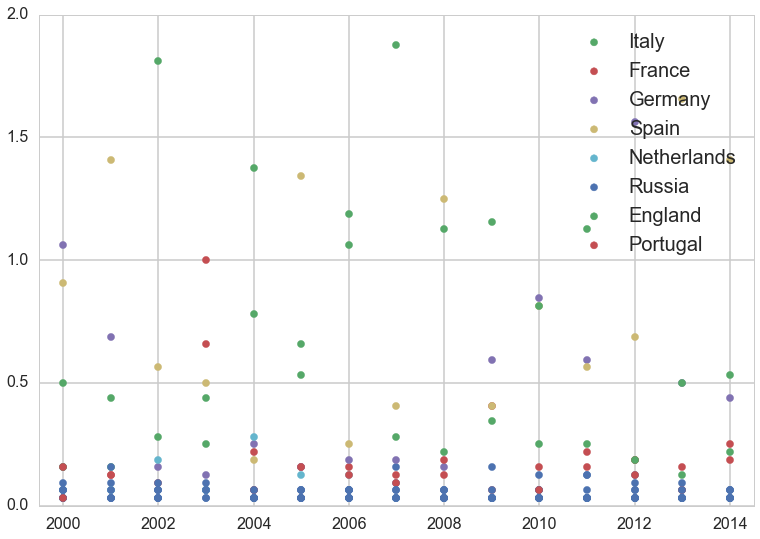

In [155]:
n = 8
c = 1
figsize=(16, 12)
cs = sns.color_palette(n_colors=n+1)
for k, vs in temp_dict.iteritems():   
    if k in [best_counties_d[c_][0] for c_ in sorted(best_counties_d.keys(), reverse=True)[:n]]:
        plott(vs, cs[c], k)
        c += 1
    else:
        plott(vs, cs[0])
    plt.xlim([1999.5,2014.5])
    plt.ylim([0, 2])
    plt.legend(loc='upper right', prop={'size':20})

In [51]:
cl_score_d_year = {}
for k, vs in cl_score_d.iteritems():
    for v in vs:
        try:
            cl_score_d_year[v[0]].append((k, v[1]))
        except KeyError:
            cl_score_d_year[v[0]] = [(k, v[1])]

In [165]:
del cl_score_d_year[2000]
del cl_score_d_year[2015]

In [228]:
cl_score_d_ = {}
for k, vs in cl_score_d_year.iteritems():
    sm = sum([v[1] for v in vs])
    sm = 3.5
    for v in vs:
        try:
            cl_score_d_[v[0]].append((k, v[1]/float(sm)))
        except KeyError:
            cl_score_d_[v[0]] = [(k, v[1]/float(sm))]

In [229]:
cl_reg = {}
for k, vs in cl_score_d_.iteritems():
    for v in vs:
        try:
            cl_reg[k].append((v[1], float(d_[k][d_[k].Year == v[0]].Gini)))
        except KeyError:
            try:
                cl_reg[k] = [(v[1], float(d_[k][d_[k].Year == v[0]].Gini))]
            except:
                pass
        except:
            pass

In [230]:
for k, v in cl_reg.iteritems():
    v_ =  pd.DataFrame(v, columns = ["Percent", "Gini"])
    lm = smf.ols(formula='Percent ~ Gini', data=v_).fit()
    print k, lm.summary(), '\n\n\n'

Italy                             OLS Regression Results                            
Dep. Variable:                Percent   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.221
Date:                Fri, 22 Jan 2016   Prob (F-statistic):              0.293
Time:                        16:52:00   Log-Likelihood:                 7.3561
No. Observations:                  13   AIC:                            -10.71
Df Residuals:                      11   BIC:                            -9.582
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5868      0.390      1.503   

In [252]:
for k, v in d_.iteritems():
    print k, v.Raw_Data

Italy 0     [71.568627451, 61.7647058824, 61.7647058824, 5...
1     [71.568627451, 63.7254901961, 57.8431372549, 5...
2     [63.7254901961, 61.7647058824, 57.8431372549, ...
3     [72.5490196078, 67.6470588235, 62.7450980392, ...
4     [68.6274509804, 67.6470588235, 54.9019607843, ...
5     [70.5882352941, 69.6078431373, 59.8039215686, ...
6     [73.5294117647, 71.568627451, 67.6470588235, 5...
7     [69.6078431373, 68.6274509804, 67.6470588235, ...
8     [70.5882352941, 63.7254901961, 59.8039215686, ...
9     [80.3921568627, 69.6078431373, 67.6470588235, ...
10    [75.4385964912, 69.298245614, 63.1578947368, 5...
11    [85.0877192982, 65.7894736842, 54.3859649123, ...
12    [74.5614035088, 71.9298245614, 63.1578947368, ...
13    [73.6842105263, 64.9122807018, 64.9122807018, ...
14    [71.9298245614, 70.1754385965, 61.4035087719, ...
15    [71.9298245614, 66.6666666667, 61.4035087719, ...
16    [73.6842105263, 70.1754385965, 56.1403508772, ...
17    [76.3157894737, 68.4210526316, 63.15

In [28]:
def temp(d):
    d_new = {}
    for year in d.keys():
        try:
            tempdf = d[year-1]
        except KeyError:
            print "Data not found for ", year-1
        else:
            d_new[year] = zip(helper(tempdf), helper(d[year]))
    return d_new


In [471]:
table_dict = {int(k): dict_to_df(v) for k, v in d.iteritems() if v is not None and int(k) != 2015}

ValueError: invalid literal for int() with base 10: 'Italy'

In [30]:
l = []
for k, v in table_dict.iteritems():
    l = l+list(v['Team'])

In [31]:
dict_to_df(d['2015'])

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,1,Leicester City,15,9,5,1,32,21,+11,32,Qualification to Champions League group stage
1,2,Arsenal,15,9,3,3,27,13,+14,30,None
2,3,Manchester City,15,9,2,4,30,16,+14,29,None
3,4,Manchester United,15,8,5,2,20,10,+10,29,Qualification to Champions League play-off round
4,5,Tottenham Hotspur,15,6,8,1,25,12,+13,26,Qualification to Europa League group stage
5,6,West Ham United,15,6,5,4,25,21,+4,23,
6,7,Liverpool,14,6,5,3,18,15,+3,23,None
7,8,Crystal Palace,14,7,1,6,19,14,+5,22,None
8,9,Watford,15,6,4,5,17,16,+1,22,None
9,10,Stoke City,15,6,4,5,13,14,−1,22,None


In [32]:
translations = {v: v for v in np.unique(l)}

In [33]:
def scrubbed(d, splits = ['\\', '!', "("]):
    tpl = d.values()
    for s in splits:
        tpl = tuple([v.split(s)[0].rstrip() for v in tpl])
    tpl = np.unique(tpl)
    for k, v in d.iteritems():
        for t in tpl:
            if t in v:
                d[k] = t
    print "Scrubbed"
    return d
        
def parsed_dict(d, rigorous = False):
    translations = d.copy()
    again = True
    while again:
        values = np.unique(translations.values())
        init_len = len(values)
        for k, v in translations.iteritems():
            for val in values:
                if val in k:
                    try:
                        translations[k] = translations[val]
                    except KeyError:
                        translations[k] = val
        fin_len = len(np.unique(translations.values()))
        if init_len == fin_len:
            print "Compressed to", fin_len
            again = False
        else:
            print "Compressing from", init_len, "to", fin_len,"..."
    if rigorous:
        return parsed_dict(scrubbed(translations))
    else:
        return translations
    
def parse(a):
    return [translations_[t] for t in a]

In [34]:
translations_ = parsed_dict(translations, rigorous=True)

Compressing from 135 to 63 ...
Compressing from 63 to 54 ...
Compressed to 54
Scrubbed
Compressed to 46


In [35]:
np.unique(translations_.values())

array([u'Arsenal', u'Aston Villa', u'Barnsley', u'Birmingham City',
       u'Blackburn Rovers', u'Blackpool', u'Bolton Wanderers',
       u'Bradford City', u'Burnley', u'Cardiff City', u'Charlton Athletic',
       u'Chelsea', u'Coventry City', u'Crystal Palace', u'Derby County',
       u'Everton', u'Fulham', u'Hull City', u'Ipswich Town',
       u'Leeds United', u'Leicester City', u'Liverpool',
       u'Manchester City', u'Manchester United', u'Middlesbrough',
       u'Newcastle United', u'Norwich City', u'Nottingham Forest',
       u'Oldham Athletic', u'Portsmouth', u'Queens Park Rangers',
       u'Reading', u'Sheffield United', u'Sheffield Wednesday',
       u'Southampton', u'Stoke City', u'Sunderland', u'Swansea City',
       u'Swindon Town', u'Tottenham Hotspur', u'Watford',
       u'West Bromwich Albion', u'West Ham United', u'Wigan Athletic',
       u'Wimbledon', u'Wolverhampton Wanderers'], 
      dtype='<U23')

In [36]:
def translate(c1, c2, translations = translations_):
    c1_ = [translations_[s] for s in c1]
    c2_ = [translations_[t] for t in c2]
    d = {}
    for i, a in enumerate(c1_):
        if a not in c2_:
            d[a] = (i+1, len(c2_)+1)
        else:
            for i_, b in enumerate(c2_):
                if b in c1_:
                    if a == b:
                        d[a] = (i+1,i_+1)
                else:
                    d[b] = (len(c1_)+1, i_+1)
                    
    return d

In [37]:
def regressify(d, translations = translations_, years_past = 1, column = "Pos", twenty=True):
    out_d = {}
    for k, v in d.iteritems():
        text = "".join([str(k-years_past),"-",str(k)])
        try:
            df = d[k-years_past]
        except KeyError:
            print "Data doesn't exist for", text
        else:
            if df.shape[0] == 20 or (twenty == False):
                out_d[text] = translate(df.Team, d[k].Team, translations_)
            else:
                print "Excluding data from", text
    return out_d

In [38]:
def compile_everything(d, translations = translations_, years_past = 1, column = "Pos", twenty=True, s_ = 10):
    data = regressify(d, translations, years_past, column, twenty)
    xs = []
    ys = []
    count_dict = {}
    for year, v in data.iteritems():
        for team, (x, y) in v.iteritems():
            xs.append(x)
            ys.append(y)
            tup = (x, y)
            try:
                count_dict[tup]
            except KeyError:
                count_dict[tup] = [1, [(team, year)]]
            else:
                count_dict[tup][0] += 1
                count_dict[tup][1].append((team,year))

    regress_df = pd.DataFrame(zip(xs,ys), columns=["X", 'y'])
    xs_, ys_ = zip(*count_dict.keys())
    print "Sanity Check"
    print len(count_dict.values())
    print sum(zip(*count_dict.values())[0])
    print len(set(zip(xs,ys)))
    print len(xs), len(xs_)
    regression = smf.ols(formula = 'y ~ X', data = regress_df).fit()
    plt.scatter(xs_, ys_, s = [r*s_ for r in zip(*count_dict.values())[0]])
    plt.xlim(0,22)
    plt.ylim(0,22)
    plt.ylabel('Table Position in Year n')
    plt.title('How Well Does Table Position in Year N-%d Correspond to Performance in Year N' % years_past)
    plt.xlabel('Table Position in Year n-%d' % years_past)
    return regression, count_dict

Data doesn't exist for 1982-1992
Data doesn't exist for 1983-1993
Data doesn't exist for 1984-1994
Data doesn't exist for 1985-1995
Data doesn't exist for 1986-1996
Data doesn't exist for 1987-1997
Data doesn't exist for 1988-1998
Data doesn't exist for 1989-1999
Data doesn't exist for 1990-2000
Data doesn't exist for 1991-2001
Excluding data from 1992-2002
Excluding data from 1993-2003
Excluding data from 1994-2004
Sanity Check
124
284
124
284 124


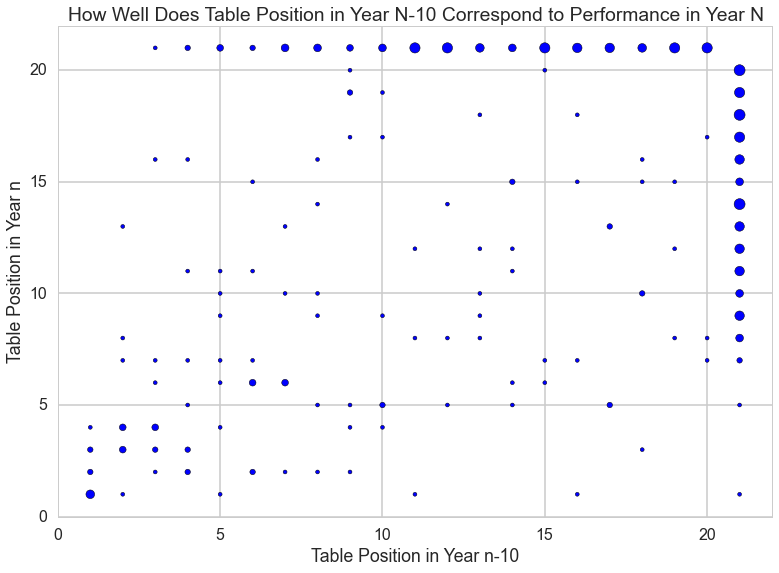

In [39]:
a,b = compile_everything(table_dict, years_past=10, s_ = 15);

In [40]:
b

{(1, 1): [5,
  [(u'Chelsea', '2004-2014'),
   (u'Manchester United', '2002-2012'),
   (u'Manchester United', '1998-2008'),
   (u'Manchester United', '2000-2010'),
   (u'Manchester United', '1996-2006')]],
 (1, 2): [2,
  [(u'Manchester United', '1999-2009'), (u'Manchester United', '1995-2005')]],
 (1, 3): [2, [(u'Arsenal', '1997-2007'), (u'Arsenal', '2001-2011')]],
 (1, 4): [1, [(u'Arsenal', '2003-2013')]],
 (2, 1): [1, [(u'Manchester United', '1997-2007')]],
 (2, 3): [3,
  [(u'Arsenal', '1999-2009'),
   (u'Arsenal', '2004-2014'),
   (u'Chelsea', '2003-2013')]],
 (2, 4): [3,
  [(u'Arsenal', '2002-2012'),
   (u'Arsenal', '1998-2008'),
   (u'Arsenal', '2000-2010')]],
 (2, 7): [1, [(u'Newcastle United', '1995-2005')]],
 (2, 8): [1, [(u'Liverpool', '2001-2011')]],
 (2, 13): [1, [(u'Newcastle United', '1996-2006')]],
 (3, 2): [1, [(u'Manchester United', '2001-2011')]],
 (3, 3): [2, [(u'Liverpool', '1995-2005'), (u'Chelsea', '1998-2008')]],
 (3, 4): [3,
  [(u'Liverpool', '1997-2007'),
   (u'M

In [41]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     49.36
Date:                Sun, 06 Dec 2015   Prob (F-statistic):           1.60e-11
Time:                        13:46:03   Log-Likelihood:                -924.91
No. Observations:                 284   AIC:                             1854.
Df Residuals:                     282   BIC:                             1861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.3544      0.836      9.995      0.000         6.709    10.000
X              0.3860      0.055      7.026      0.000         0.278     0.494
==============================================================================
Omnibus:                      153.006   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.127
Skew:                           0.012   Prob(JB):                     0.000191
Kurtosis:                       1.797   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
%%time
%%capture
pval_dict = {}
for y in range (1,30):
    try:
        val = compile_everything(table_dict, years_past=y)[0].pvalues
    except ValueError:
        break
    else:
        pval_dict[y] = val

Wall time: 927 ms


In [43]:
np.log(zip(*pval_dict.values())[1])

array([-176.34778368, -114.74097342,  -80.25983041,  -64.58947866,
        -48.51878256,  -42.66358359,  -35.45639567,  -28.25714346,
        -26.58621145,  -24.85872235,  -20.15122047,  -16.61797851,
        -10.34196403,   -8.62211346,   -7.73595166,   -4.87580611,
         -4.21975887,   -3.73024801,   -1.29312329])

In [44]:
pval_dict.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

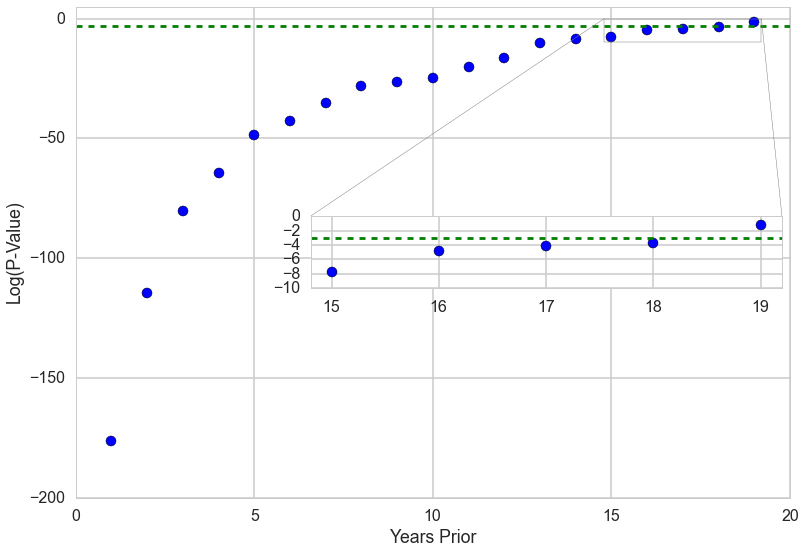

In [45]:
fig, ax = plt.subplots()
plt.axhline(y = np.log(.05), c = 'g', linestyle = 'dashed')
plt.scatter(y = np.log(zip(*pval_dict.values())[1]), x = pval_dict.keys(), s = 100, c = 'b')
plt.ylim([-200,5])
plt.xlabel('Years Prior')
plt.ylabel('Log(P-Value)');


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 3, loc=5)
plt.axhline(y = np.log(.05), c = 'g', linestyle = 'dashed')
plt.scatter(y = np.log(zip(*pval_dict.values())[1]), x = pval_dict.keys(), s = 100, c = 'b')
axins.set_xlim(14.8, 19.2) # apply the x-limits
axins.set_ylim(-10, 0)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5");
